# Some of the code is referenced or taken from the following pages
**MRI脑图像处理-归一化：python,自适应归一化**
https://blog.csdn.net/chenran187906/article/details/108575305


**MR 的几种归一化方法总结**
https://blog.csdn.net/zzhouzhou237/article/details/110238275

**用于医学图像分割的数据增强方法 —— 标准imgaug库的使用方法**
https://blog.csdn.net/JYZhang_CVML/article/details/102575599

**数据预处理归一化Z-score归一化Min-Max归一化程序-爱代码爱编程**
https://icode.best/i/74591830766964

**【Keras】使用数据生成器（data generators）解决训练数据内存问题**
https://blog.csdn.net/m0_37477175/article/details/79716312

**keras如何创建自己的generator**
https://blog.csdn.net/xiadimichen14908/article/details/89313592

**Tensorflow2.0 医学图像分割(大脑肿瘤识别)**
https://blog.csdn.net/qq_38412266/article/details/107300367

# CNN-based Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed. 

In [ ]:
#一定要运行
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#一定要运行
#!pip install pandas
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
#!pip install SimpleITK
#import SimpleITK as sitk
import tensorflow
from sklearn import preprocessing

import cv2
from glob import glob
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model, save_model
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Resize


from albumentations import *

In [ ]:
print("============查看GPU信息================")
# 查看GPU信息
!/opt/bin/nvidia-smi

============查看GPU信息================
Thu Aug 11 06:12:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    31W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                    

## Visualise MRI Volume Slices and Segmentation Maps
Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which is like pixels in 2D images. Here we visualise the transverse plane (usually has a higher resolution) of some of the volumes and the corresponding segmentation maps.

In [ ]:
im_width = 240
im_height = 240

#数据集路径
img_files = glob('/content/drive/MyDrive/Colab Notebooks/Dataset/Yes/*_img.npy')
mask_files = []

for i in img_files:
    mask_files.append(i.replace('_img.npy','_seg.npy'))

#打印数据集大小
print(len(img_files))
print(len(mask_files))

3319
3319


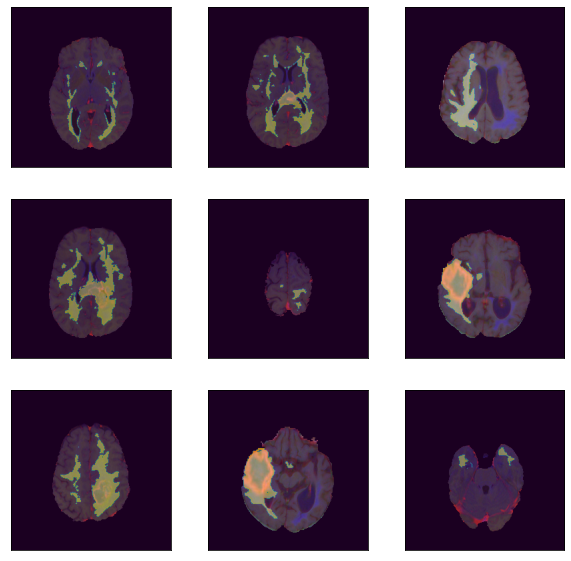

In [ ]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)

    img = np.load(img_files[i])
    #print(img)
    seg = np.load(mask_files[i])

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    #seg = (seg - np.min(seg)) / (np.max(seg) - np.min(seg))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    #seg = np.load(seg)
    #msk=cv2.imread(msk_path)
    #seg=cv2.cvtColor(seg,cv2.COLOR_RGB2BGR)

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.imshow(seg,alpha=0.4)
plt.show()

In [ ]:
train_list, test_list = train_test_split(img_files,test_size = 0.1)
train_list, val_list = train_test_split(train_list,test_size = 0.2)
print(len(train_list))
print(len(val_list))
print(len(test_list))

2389
598
332


## Data preprocessing (Optional)

Images in the original dataset are usually in different sizes, so sometimes we need to resize and normalise (z-score is commonly used in preprocessing the MRI images) them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods. If preprocessing methods like cropping is applied, remember to convert the segmentation result back to its original size. 

## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc.

You are encouraged to try different augmentation method to get the best segmentation result.


## Get the data generator ready

In [ ]:
def augmentation(img, mask):
    img = Compose([
    # 随机裁剪
    RandomSizedCrop(min_max_height=(224, 224), height=240, width=240, interpolation=cv2.INTER_NEAREST, p=1),
 
    # 非破坏性转换
    VerticalFlip(p=0.5), # 随机垂直翻转
    RandomRotate90(p=0.5), # 随机旋转90度
    # 非刚体转换
    OneOf([
        ElasticTransform(p=0.5, interpolation=cv2.INTER_NEAREST), # 弹性变换
        GridDistortion(p=0.5, interpolation=cv2.INTER_NEAREST), # 网格畸变
        OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5, interpolation=cv2.INTER_NEAREST) # 光学畸变
        ], p=0),
    # 非空间性转换
    RandomBrightnessContrast(p=0), # 随机改变亮度对比度
    ])(image=img, mask=mask)
    return img

'''plt.figure(figsize=(5,5))
img1 = np.load(img_files[1145])[:,:,:]
seg1 = np.load(mask_files[1145])[:,:]
print(type(img1))
print(img1.shape)
img1 = (img1 - np.min(img1)) / (np.max(img1) - np.min(img1))
print(type(img1))
print(img1.dtype)
#seg1 = (seg1 - np.min(seg1)) / (np.max(seg1) - np.min(seg1))
plt.subplot(2,2,1)
plt.imshow(img1)
plt.subplot(2,2,2)
plt.imshow(seg1, cmap='gray')
 
imgAf = augmentation(img1, seg1)
print(type(imgAf["image"]))
print(imgAf["image"].dtype)

plt.subplot(2,2,3)
plt.imshow(imgAf["image"])
plt.subplot(2,2,4)
plt.imshow(imgAf["mask"], cmap='gray')
plt.tight_layout()
plt.show()'''

'plt.figure(figsize=(5,5))\nimg1 = np.load(img_files[1145])[:,:,:]\nseg1 = np.load(mask_files[1145])[:,:]\nprint(type(img1))\nprint(img1.shape)\nimg1 = (img1 - np.min(img1)) / (np.max(img1) - np.min(img1))\nprint(type(img1))\nprint(img1.dtype)\n#seg1 = (seg1 - np.min(seg1)) / (np.max(seg1) - np.min(seg1))\nplt.subplot(2,2,1)\nplt.imshow(img1)\nplt.subplot(2,2,2)\nplt.imshow(seg1, cmap=\'gray\')\n \nimgAf = augmentation(img1, seg1)\nprint(type(imgAf["image"]))\nprint(imgAf["image"].dtype)\n\nplt.subplot(2,2,3)\nplt.imshow(imgAf["image"])\nplt.subplot(2,2,4)\nplt.imshow(imgAf["mask"], cmap=\'gray\')\nplt.tight_layout()\nplt.show()'

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty(shape=(self.batch_size, *self.dim, self.n_channels))
        y = np.empty(shape=(self.batch_size, *self.dim))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            
            X[i] = np.load(ID)
            #X[i] = (img1 - np.min(img1)) / (np.max(img1) - np.min(img1))
            y[i] = np.load(ID.replace('_img.npy','_seg.npy'))
            #print(X[i].shape)
            #print(y[i].shape)

            #X[i] = (img1 - np.min(img1)) / (np.max(img1) - np.min(img1))
            #seg1 = (seg1 - np.min(seg1)) / (np.max(seg1) - np.min(seg1))
            # Add data augmentation here
            imgAf = augmentation(X[i], y[i])
            # Store class
            #print(imgAf['image'])
            #print(type(imgAf['image']))
            X[i] = imgAf['image']#.astype(dtype=np.float32)
            y[i] = imgAf['mask']#.astype(dtype=np.float32)

        return X,y

## Define a metric for the performance of the model
Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. Dice score can be also used as the loss function for training your model.

In [ ]:
smooth=100
#定义Dice系数
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))
    
#定义损失函数
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#定义iou函数
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

## Build your own model here
The U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is widely used for the medical image segmentation task. You can build your own model or modify the UNet by changing the hyperparameters for our task. If you choose to use Keras, more information about the Keras layers including Conv2D, MaxPooling and Dropout can be found at https://keras.io/api/layers/.

In [ ]:
def unet(input_size=(240,240,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])
    
model = unet()
#打印模型参数
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 240, 240, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## Train your model here
Once you defined the model and data generator, you can start training your model.

Learning rate schedule: 1e-05 to 0.0004 to 1e-05


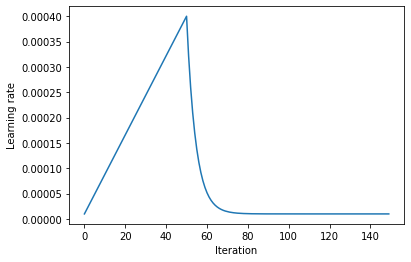

In [15]:
EPOCHS = 150
BATCH_SIZE = 32

def lrfn(epoch):
    LR_START = 0.00001
    LR_MAX = 0.0004
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 50
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [ ]:
#生成训练数据
train_gen = DataGenerator(train_list)
#生成验证数据    
test_gener = DataGenerator(val_list)
                                    
model = unet(input_size=(im_height, im_width, 3))

checkpoint = ModelCheckpoint(
                                filepath='myUnet.hdf5',
                                monitor='val_acc',
                                save_weights_only=False,
                                save_best_only=True,
                                mode='auto',
                                period=1
                            )
#编译模型
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef], run_eagerly=True)

#开始训练
history = model.fit(train_gen,
                    #steps_per_epoch=int(len(df_train) / BATCH_SIZE),
                    epochs=EPOCHS,
                    callbacks=[lr_schedule,checkpoint],
                    validation_data = test_gener
                    #validation_steps=int(len(df_val) / BATCH_SIZE),
                    )#[lr_schedule,checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/70
74/74 [==============================] - ETA: 0s - loss: -0.1041 - binary_accuracy: 0.5178 - iou: 0.0551 - dice_coef: 0.1041

74/74 [==============================] - 81s 918ms/step - loss: -0.1041 - binary_accuracy: 0.5178 - iou: 0.0551 - dice_coef: 0.1041 - val_loss: -0.0694 - val_binary_accuracy: 0.5194 - val_iou: 0.0360 - val_dice_coef: 0.0694 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.78e-05.
Epoch 2/70
74/74 [==============================] - ETA: 0s - loss: -0.1822 - binary_accuracy: 0.9197 - iou: 0.1007 - dice_coef: 0.1822

74/74 [==============================] - 66s 896ms/step - loss: -0.1822 - binary_accuracy: 0.9197 - iou: 0.1007 - dice_coef: 0.1822 - val_loss: -0.0992 - val_binary_accuracy: 0.9668 - val_iou: 0.0523 - val_dice_coef: 0.0992 - lr: 1.7800e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.56e-05.
Epoch 3/70
74/74 [==============================] - ETA: 0s - loss: -0.2429 - binary_accuracy: 0.9785 - iou: 0.1387 - dice_coef: 0.2429

74/74 [==============================] - 66s 894ms/step - loss: -0.2429 - binary_accuracy: 0.9785 - iou: 0.1387 - dice_coef: 0.2429 - val_loss: -0.1542 - val_binary_accuracy: 0.9045 - val_iou: 0.0836 - val_dice_coef: 0.1542 - lr: 2.5600e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.34e-05.
Epoch 4/70
74/74 [==============================] - ETA: 0s - loss: -0.2699 - binary_accuracy: 0.9845 - iou: 0.1565 - dice_coef: 0.2699

74/74 [==============================] - 66s 893ms/step - loss: -0.2699 - binary_accuracy: 0.9845 - iou: 0.1565 - dice_coef: 0.2699 - val_loss: -0.1571 - val_binary_accuracy: 0.8316 - val_iou: 0.0854 - val_dice_coef: 0.1571 - lr: 3.3400e-05

Epoch 5: LearningRateScheduler setting learning rate to 4.12e-05.
Epoch 5/70
74/74 [==============================] - ETA: 0s - loss: -0.2887 - binary_accuracy: 0.9860 - iou: 0.1693 - dice_coef: 0.2887

74/74 [==============================] - 66s 892ms/step - loss: -0.2887 - binary_accuracy: 0.9860 - iou: 0.1693 - dice_coef: 0.2887 - val_loss: -0.1976 - val_binary_accuracy: 0.8803 - val_iou: 0.1099 - val_dice_coef: 0.1976 - lr: 4.1200e-05

Epoch 6: LearningRateScheduler setting learning rate to 4.9e-05.
Epoch 6/70
74/74 [==============================] - ETA: 0s - loss: -0.3085 - binary_accuracy: 0.9874 - iou: 0.1830 - dice_coef: 0.3085

74/74 [==============================] - 66s 893ms/step - loss: -0.3085 - binary_accuracy: 0.9874 - iou: 0.1830 - dice_coef: 0.3085 - val_loss: -0.2916 - val_binary_accuracy: 0.9780 - val_iou: 0.1710 - val_dice_coef: 0.2916 - lr: 4.9000e-05

Epoch 7: LearningRateScheduler setting learning rate to 5.68e-05.
Epoch 7/70
74/74 [==============================] - ETA: 0s - loss: -0.3293 - binary_accuracy: 0.9883 - iou: 0.1977 - dice_coef: 0.3293

74/74 [==============================] - 66s 893ms/step - loss: -0.3293 - binary_accuracy: 0.9883 - iou: 0.1977 - dice_coef: 0.3293 - val_loss: -0.3247 - val_binary_accuracy: 0.9899 - val_iou: 0.1946 - val_dice_coef: 0.3247 - lr: 5.6800e-05

Epoch 8: LearningRateScheduler setting learning rate to 6.46e-05.
Epoch 8/70
74/74 [==============================] - ETA: 0s - loss: -0.3519 - binary_accuracy: 0.9893 - iou: 0.2142 - dice_coef: 0.3519

74/74 [==============================] - 66s 893ms/step - loss: -0.3519 - binary_accuracy: 0.9893 - iou: 0.2142 - dice_coef: 0.3519 - val_loss: -0.3354 - val_binary_accuracy: 0.9755 - val_iou: 0.2019 - val_dice_coef: 0.3354 - lr: 6.4600e-05

Epoch 9: LearningRateScheduler setting learning rate to 7.24e-05.
Epoch 9/70
74/74 [==============================] - ETA: 0s - loss: -0.3775 - binary_accuracy: 0.9900 - iou: 0.2334 - dice_coef: 0.3775

74/74 [==============================] - 66s 893ms/step - loss: -0.3775 - binary_accuracy: 0.9900 - iou: 0.2334 - dice_coef: 0.3775 - val_loss: -0.3779 - val_binary_accuracy: 0.9904 - val_iou: 0.2334 - val_dice_coef: 0.3779 - lr: 7.2400e-05

Epoch 10: LearningRateScheduler setting learning rate to 8.02e-05.
Epoch 10/70
74/74 [==============================] - ETA: 0s - loss: -0.4044 - binary_accuracy: 0.9903 - iou: 0.2543 - dice_coef: 0.4044

74/74 [==============================] - 66s 893ms/step - loss: -0.4044 - binary_accuracy: 0.9903 - iou: 0.2543 - dice_coef: 0.4044 - val_loss: -0.4067 - val_binary_accuracy: 0.9928 - val_iou: 0.2559 - val_dice_coef: 0.4067 - lr: 8.0200e-05

Epoch 11: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 11/70
74/74 [==============================] - ETA: 0s - loss: -0.4339 - binary_accuracy: 0.9906 - iou: 0.2780 - dice_coef: 0.4339

74/74 [==============================] - 66s 892ms/step - loss: -0.4339 - binary_accuracy: 0.9906 - iou: 0.2780 - dice_coef: 0.4339 - val_loss: -0.4364 - val_binary_accuracy: 0.9900 - val_iou: 0.2805 - val_dice_coef: 0.4364 - lr: 8.8000e-05

Epoch 12: LearningRateScheduler setting learning rate to 9.58e-05.
Epoch 12/70
74/74 [==============================] - ETA: 0s - loss: -0.4720 - binary_accuracy: 0.9918 - iou: 0.3100 - dice_coef: 0.4720

74/74 [==============================] - 66s 892ms/step - loss: -0.4720 - binary_accuracy: 0.9918 - iou: 0.3100 - dice_coef: 0.4720 - val_loss: -0.4594 - val_binary_accuracy: 0.9936 - val_iou: 0.2993 - val_dice_coef: 0.4594 - lr: 9.5800e-05

Epoch 13: LearningRateScheduler setting learning rate to 0.0001036.
Epoch 13/70
74/74 [==============================] - ETA: 0s - loss: -0.5118 - binary_accuracy: 0.9923 - iou: 0.3452 - dice_coef: 0.5118

74/74 [==============================] - 66s 892ms/step - loss: -0.5118 - binary_accuracy: 0.9923 - iou: 0.3452 - dice_coef: 0.5118 - val_loss: -0.5160 - val_binary_accuracy: 0.9878 - val_iou: 0.3486 - val_dice_coef: 0.5160 - lr: 1.0360e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0001114.
Epoch 14/70
74/74 [==============================] - ETA: 0s - loss: -0.5563 - binary_accuracy: 0.9928 - iou: 0.3868 - dice_coef: 0.5563

74/74 [==============================] - 66s 892ms/step - loss: -0.5563 - binary_accuracy: 0.9928 - iou: 0.3868 - dice_coef: 0.5563 - val_loss: -0.5508 - val_binary_accuracy: 0.9906 - val_iou: 0.3812 - val_dice_coef: 0.5508 - lr: 1.1140e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0001192.
Epoch 15/70
74/74 [==============================] - ETA: 0s - loss: -0.5993 - binary_accuracy: 0.9930 - iou: 0.4294 - dice_coef: 0.5993

74/74 [==============================] - 66s 892ms/step - loss: -0.5993 - binary_accuracy: 0.9930 - iou: 0.4294 - dice_coef: 0.5993 - val_loss: -0.6251 - val_binary_accuracy: 0.9939 - val_iou: 0.4562 - val_dice_coef: 0.6251 - lr: 1.1920e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.000127.
Epoch 16/70
74/74 [==============================] - ETA: 0s - loss: -0.6445 - binary_accuracy: 0.9936 - iou: 0.4768 - dice_coef: 0.6445

74/74 [==============================] - 66s 892ms/step - loss: -0.6445 - binary_accuracy: 0.9936 - iou: 0.4768 - dice_coef: 0.6445 - val_loss: -0.6553 - val_binary_accuracy: 0.9940 - val_iou: 0.4883 - val_dice_coef: 0.6553 - lr: 1.2700e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0001348.
Epoch 17/70
74/74 [==============================] - ETA: 0s - loss: -0.6842 - binary_accuracy: 0.9936 - iou: 0.5214 - dice_coef: 0.6842

74/74 [==============================] - 66s 892ms/step - loss: -0.6842 - binary_accuracy: 0.9936 - iou: 0.5214 - dice_coef: 0.6842 - val_loss: -0.6788 - val_binary_accuracy: 0.9940 - val_iou: 0.5147 - val_dice_coef: 0.6788 - lr: 1.3480e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0001426.
Epoch 18/70
74/74 [==============================] - ETA: 0s - loss: -0.7151 - binary_accuracy: 0.9933 - iou: 0.5579 - dice_coef: 0.7151

74/74 [==============================] - 66s 892ms/step - loss: -0.7151 - binary_accuracy: 0.9933 - iou: 0.5579 - dice_coef: 0.7151 - val_loss: -0.7101 - val_binary_accuracy: 0.9923 - val_iou: 0.5515 - val_dice_coef: 0.7101 - lr: 1.4260e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0001504.
Epoch 19/70
74/74 [==============================] - ETA: 0s - loss: -0.7548 - binary_accuracy: 0.9941 - iou: 0.6074 - dice_coef: 0.7548

74/74 [==============================] - 66s 892ms/step - loss: -0.7548 - binary_accuracy: 0.9941 - iou: 0.6074 - dice_coef: 0.7548 - val_loss: -0.7606 - val_binary_accuracy: 0.9944 - val_iou: 0.6147 - val_dice_coef: 0.7606 - lr: 1.5040e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001582.
Epoch 20/70
74/74 [==============================] - ETA: 0s - loss: -0.7829 - binary_accuracy: 0.9943 - iou: 0.6443 - dice_coef: 0.7829

74/74 [==============================] - 66s 892ms/step - loss: -0.7829 - binary_accuracy: 0.9943 - iou: 0.6443 - dice_coef: 0.7829 - val_loss: -0.6786 - val_binary_accuracy: 0.9814 - val_iou: 0.5148 - val_dice_coef: 0.6786 - lr: 1.5820e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.000166.
Epoch 21/70
74/74 [==============================] - ETA: 0s - loss: -0.7979 - binary_accuracy: 0.9939 - iou: 0.6648 - dice_coef: 0.7979

74/74 [==============================] - 66s 892ms/step - loss: -0.7979 - binary_accuracy: 0.9939 - iou: 0.6648 - dice_coef: 0.7979 - val_loss: -0.7719 - val_binary_accuracy: 0.9905 - val_iou: 0.6298 - val_dice_coef: 0.7719 - lr: 1.6600e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0001738.
Epoch 22/70
74/74 [==============================] - ETA: 0s - loss: -0.8204 - binary_accuracy: 0.9942 - iou: 0.6962 - dice_coef: 0.8204

74/74 [==============================] - 66s 892ms/step - loss: -0.8204 - binary_accuracy: 0.9942 - iou: 0.6962 - dice_coef: 0.8204 - val_loss: -0.8275 - val_binary_accuracy: 0.9939 - val_iou: 0.7064 - val_dice_coef: 0.8275 - lr: 1.7380e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0001816.
Epoch 23/70
74/74 [==============================] - ETA: 0s - loss: -0.8401 - binary_accuracy: 0.9946 - iou: 0.7250 - dice_coef: 0.8401

74/74 [==============================] - 66s 892ms/step - loss: -0.8401 - binary_accuracy: 0.9946 - iou: 0.7250 - dice_coef: 0.8401 - val_loss: -0.8374 - val_binary_accuracy: 0.9937 - val_iou: 0.7212 - val_dice_coef: 0.8374 - lr: 1.8160e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0001894.
Epoch 24/70
74/74 [==============================] - ETA: 0s - loss: -0.8534 - binary_accuracy: 0.9948 - iou: 0.7450 - dice_coef: 0.8534

74/74 [==============================] - 66s 892ms/step - loss: -0.8534 - binary_accuracy: 0.9948 - iou: 0.7450 - dice_coef: 0.8534 - val_loss: -0.8464 - val_binary_accuracy: 0.9945 - val_iou: 0.7344 - val_dice_coef: 0.8464 - lr: 1.8940e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0001972.
Epoch 25/70
74/74 [==============================] - ETA: 0s - loss: -0.8558 - binary_accuracy: 0.9943 - iou: 0.7486 - dice_coef: 0.8558

74/74 [==============================] - 66s 893ms/step - loss: -0.8558 - binary_accuracy: 0.9943 - iou: 0.7486 - dice_coef: 0.8558 - val_loss: -0.8475 - val_binary_accuracy: 0.9941 - val_iou: 0.7361 - val_dice_coef: 0.8475 - lr: 1.9720e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.000205.
Epoch 26/70
74/74 [==============================] - ETA: 0s - loss: -0.8697 - binary_accuracy: 0.9948 - iou: 0.7702 - dice_coef: 0.8697

74/74 [==============================] - 66s 892ms/step - loss: -0.8697 - binary_accuracy: 0.9948 - iou: 0.7702 - dice_coef: 0.8697 - val_loss: -0.8397 - val_binary_accuracy: 0.9919 - val_iou: 0.7243 - val_dice_coef: 0.8397 - lr: 2.0500e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0002128.
Epoch 27/70
74/74 [==============================] - ETA: 0s - loss: -0.8753 - binary_accuracy: 0.9947 - iou: 0.7789 - dice_coef: 0.8753

74/74 [==============================] - 66s 892ms/step - loss: -0.8753 - binary_accuracy: 0.9947 - iou: 0.7789 - dice_coef: 0.8753 - val_loss: -0.8749 - val_binary_accuracy: 0.9947 - val_iou: 0.7784 - val_dice_coef: 0.8749 - lr: 2.1280e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0002206.
Epoch 28/70
74/74 [==============================] - ETA: 0s - loss: -0.8805 - binary_accuracy: 0.9948 - iou: 0.7871 - dice_coef: 0.8805

74/74 [==============================] - 66s 892ms/step - loss: -0.8805 - binary_accuracy: 0.9948 - iou: 0.7871 - dice_coef: 0.8805 - val_loss: -0.8728 - val_binary_accuracy: 0.9944 - val_iou: 0.7750 - val_dice_coef: 0.8728 - lr: 2.2060e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0002284.
Epoch 29/70
74/74 [==============================] - ETA: 0s - loss: -0.8841 - binary_accuracy: 0.9947 - iou: 0.7930 - dice_coef: 0.8841

74/74 [==============================] - 66s 892ms/step - loss: -0.8841 - binary_accuracy: 0.9947 - iou: 0.7930 - dice_coef: 0.8841 - val_loss: -0.8043 - val_binary_accuracy: 0.9911 - val_iou: 0.6746 - val_dice_coef: 0.8043 - lr: 2.2840e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0002362.
Epoch 30/70
74/74 [==============================] - ETA: 0s - loss: -0.8882 - binary_accuracy: 0.9948 - iou: 0.7994 - dice_coef: 0.8882

74/74 [==============================] - 66s 892ms/step - loss: -0.8882 - binary_accuracy: 0.9948 - iou: 0.7994 - dice_coef: 0.8882 - val_loss: -0.8444 - val_binary_accuracy: 0.9908 - val_iou: 0.7314 - val_dice_coef: 0.8444 - lr: 2.3620e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.000244.
Epoch 31/70
74/74 [==============================] - ETA: 0s - loss: -0.8896 - binary_accuracy: 0.9946 - iou: 0.8017 - dice_coef: 0.8896

74/74 [==============================] - 66s 892ms/step - loss: -0.8896 - binary_accuracy: 0.9946 - iou: 0.8017 - dice_coef: 0.8896 - val_loss: -0.8911 - val_binary_accuracy: 0.9946 - val_iou: 0.8039 - val_dice_coef: 0.8911 - lr: 2.4400e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0002518.
Epoch 32/70
74/74 [==============================] - ETA: 0s - loss: -0.8892 - binary_accuracy: 0.9945 - iou: 0.8012 - dice_coef: 0.8892

74/74 [==============================] - 66s 892ms/step - loss: -0.8892 - binary_accuracy: 0.9945 - iou: 0.8012 - dice_coef: 0.8892 - val_loss: -0.8928 - val_binary_accuracy: 0.9947 - val_iou: 0.8070 - val_dice_coef: 0.8928 - lr: 2.5180e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0002596.
Epoch 33/70
74/74 [==============================] - ETA: 0s - loss: -0.8978 - binary_accuracy: 0.9949 - iou: 0.8149 - dice_coef: 0.8978

74/74 [==============================] - 66s 892ms/step - loss: -0.8978 - binary_accuracy: 0.9949 - iou: 0.8149 - dice_coef: 0.8978 - val_loss: -0.8985 - val_binary_accuracy: 0.9951 - val_iou: 0.8161 - val_dice_coef: 0.8985 - lr: 2.5960e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0002674.
Epoch 34/70
74/74 [==============================] - ETA: 0s - loss: -0.9001 - binary_accuracy: 0.9948 - iou: 0.8187 - dice_coef: 0.9001

74/74 [==============================] - 66s 892ms/step - loss: -0.9001 - binary_accuracy: 0.9948 - iou: 0.8187 - dice_coef: 0.9001 - val_loss: -0.8930 - val_binary_accuracy: 0.9944 - val_iou: 0.8073 - val_dice_coef: 0.8930 - lr: 2.6740e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0002752.
Epoch 35/70
74/74 [==============================] - ETA: 0s - loss: -0.9055 - binary_accuracy: 0.9951 - iou: 0.8278 - dice_coef: 0.9055

74/74 [==============================] - 66s 892ms/step - loss: -0.9055 - binary_accuracy: 0.9951 - iou: 0.8278 - dice_coef: 0.9055 - val_loss: -0.9029 - val_binary_accuracy: 0.9951 - val_iou: 0.8235 - val_dice_coef: 0.9029 - lr: 2.7520e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.00028300000000000005.
Epoch 36/70
74/74 [==============================] - ETA: 0s - loss: -0.9062 - binary_accuracy: 0.9951 - iou: 0.8289 - dice_coef: 0.9062

74/74 [==============================] - 66s 892ms/step - loss: -0.9062 - binary_accuracy: 0.9951 - iou: 0.8289 - dice_coef: 0.9062 - val_loss: -0.9057 - val_binary_accuracy: 0.9950 - val_iou: 0.8280 - val_dice_coef: 0.9057 - lr: 2.8300e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0002908.
Epoch 37/70
74/74 [==============================] - ETA: 0s - loss: -0.9062 - binary_accuracy: 0.9950 - iou: 0.8290 - dice_coef: 0.9062

74/74 [==============================] - 66s 892ms/step - loss: -0.9062 - binary_accuracy: 0.9950 - iou: 0.8290 - dice_coef: 0.9062 - val_loss: -0.8996 - val_binary_accuracy: 0.9946 - val_iou: 0.8179 - val_dice_coef: 0.8996 - lr: 2.9080e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0002986.
Epoch 38/70
74/74 [==============================] - ETA: 0s - loss: -0.9094 - binary_accuracy: 0.9951 - iou: 0.8342 - dice_coef: 0.9094

74/74 [==============================] - 66s 892ms/step - loss: -0.9094 - binary_accuracy: 0.9951 - iou: 0.8342 - dice_coef: 0.9094 - val_loss: -0.9116 - val_binary_accuracy: 0.9951 - val_iou: 0.8378 - val_dice_coef: 0.9116 - lr: 2.9860e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0003064.
Epoch 39/70
74/74 [==============================] - ETA: 0s - loss: -0.9117 - binary_accuracy: 0.9952 - iou: 0.8382 - dice_coef: 0.9117

74/74 [==============================] - 66s 892ms/step - loss: -0.9117 - binary_accuracy: 0.9952 - iou: 0.8382 - dice_coef: 0.9117 - val_loss: -0.9064 - val_binary_accuracy: 0.9949 - val_iou: 0.8293 - val_dice_coef: 0.9064 - lr: 3.0640e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.00031420000000000005.
Epoch 40/70
74/74 [==============================] - ETA: 0s - loss: -0.9139 - binary_accuracy: 0.9953 - iou: 0.8418 - dice_coef: 0.9139

74/74 [==============================] - 66s 892ms/step - loss: -0.9139 - binary_accuracy: 0.9953 - iou: 0.8418 - dice_coef: 0.9139 - val_loss: -0.8980 - val_binary_accuracy: 0.9946 - val_iou: 0.8152 - val_dice_coef: 0.8980 - lr: 3.1420e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.000322.
Epoch 41/70
74/74 [==============================] - ETA: 0s - loss: -0.9131 - binary_accuracy: 0.9952 - iou: 0.8406 - dice_coef: 0.9131

74/74 [==============================] - 66s 892ms/step - loss: -0.9131 - binary_accuracy: 0.9952 - iou: 0.8406 - dice_coef: 0.9131 - val_loss: -0.9034 - val_binary_accuracy: 0.9944 - val_iou: 0.8243 - val_dice_coef: 0.9034 - lr: 3.2200e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0003298.
Epoch 42/70
74/74 [==============================] - ETA: 0s - loss: -0.9136 - binary_accuracy: 0.9952 - iou: 0.8415 - dice_coef: 0.9136

74/74 [==============================] - 66s 892ms/step - loss: -0.9136 - binary_accuracy: 0.9952 - iou: 0.8415 - dice_coef: 0.9136 - val_loss: -0.9117 - val_binary_accuracy: 0.9950 - val_iou: 0.8381 - val_dice_coef: 0.9117 - lr: 3.2980e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0003376.
Epoch 43/70
74/74 [==============================] - ETA: 0s - loss: -0.9161 - binary_accuracy: 0.9953 - iou: 0.8456 - dice_coef: 0.9161

74/74 [==============================] - 66s 892ms/step - loss: -0.9161 - binary_accuracy: 0.9953 - iou: 0.8456 - dice_coef: 0.9161 - val_loss: -0.9051 - val_binary_accuracy: 0.9945 - val_iou: 0.8271 - val_dice_coef: 0.9051 - lr: 3.3760e-04

Epoch 44: LearningRateScheduler setting learning rate to 0.00034540000000000005.
Epoch 44/70
74/74 [==============================] - ETA: 0s - loss: -0.9172 - binary_accuracy: 0.9953 - iou: 0.8473 - dice_coef: 0.9172

74/74 [==============================] - 66s 894ms/step - loss: -0.9172 - binary_accuracy: 0.9953 - iou: 0.8473 - dice_coef: 0.9172 - val_loss: -0.9162 - val_binary_accuracy: 0.9953 - val_iou: 0.8457 - val_dice_coef: 0.9162 - lr: 3.4540e-04

Epoch 45: LearningRateScheduler setting learning rate to 0.0003532.
Epoch 45/70
74/74 [==============================] - ETA: 0s - loss: -0.9179 - binary_accuracy: 0.9953 - iou: 0.8487 - dice_coef: 0.9179

74/74 [==============================] - 66s 892ms/step - loss: -0.9179 - binary_accuracy: 0.9953 - iou: 0.8487 - dice_coef: 0.9179 - val_loss: -0.8292 - val_binary_accuracy: 0.9914 - val_iou: 0.7095 - val_dice_coef: 0.8292 - lr: 3.5320e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.000361.
Epoch 46/70
74/74 [==============================] - ETA: 0s - loss: -0.9134 - binary_accuracy: 0.9951 - iou: 0.8410 - dice_coef: 0.9134

74/74 [==============================] - 66s 892ms/step - loss: -0.9134 - binary_accuracy: 0.9951 - iou: 0.8410 - dice_coef: 0.9134 - val_loss: -0.9138 - val_binary_accuracy: 0.9952 - val_iou: 0.8415 - val_dice_coef: 0.9138 - lr: 3.6100e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0003688.
Epoch 47/70
74/74 [==============================] - ETA: 0s - loss: -0.9179 - binary_accuracy: 0.9953 - iou: 0.8485 - dice_coef: 0.9179

74/74 [==============================] - 66s 892ms/step - loss: -0.9179 - binary_accuracy: 0.9953 - iou: 0.8485 - dice_coef: 0.9179 - val_loss: -0.9153 - val_binary_accuracy: 0.9951 - val_iou: 0.8441 - val_dice_coef: 0.9153 - lr: 3.6880e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.00037660000000000005.
Epoch 48/70
74/74 [==============================] - ETA: 0s - loss: -0.9188 - binary_accuracy: 0.9953 - iou: 0.8502 - dice_coef: 0.9188

74/74 [==============================] - 66s 892ms/step - loss: -0.9188 - binary_accuracy: 0.9953 - iou: 0.8502 - dice_coef: 0.9188 - val_loss: -0.9017 - val_binary_accuracy: 0.9944 - val_iou: 0.8216 - val_dice_coef: 0.9017 - lr: 3.7660e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0003844.
Epoch 49/70
74/74 [==============================] - ETA: 0s - loss: -0.9130 - binary_accuracy: 0.9950 - iou: 0.8405 - dice_coef: 0.9130

74/74 [==============================] - 66s 892ms/step - loss: -0.9130 - binary_accuracy: 0.9950 - iou: 0.8405 - dice_coef: 0.9130 - val_loss: -0.9094 - val_binary_accuracy: 0.9947 - val_iou: 0.8342 - val_dice_coef: 0.9094 - lr: 3.8440e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0003922.
Epoch 50/70
74/74 [==============================] - ETA: 0s - loss: -0.9168 - binary_accuracy: 0.9952 - iou: 0.8468 - dice_coef: 0.9168

74/74 [==============================] - 66s 892ms/step - loss: -0.9168 - binary_accuracy: 0.9952 - iou: 0.8468 - dice_coef: 0.9168 - val_loss: -0.8756 - val_binary_accuracy: 0.9920 - val_iou: 0.7795 - val_dice_coef: 0.8756 - lr: 3.9220e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0004.
Epoch 51/70
74/74 [==============================] - ETA: 0s - loss: -0.9100 - binary_accuracy: 0.9948 - iou: 0.8354 - dice_coef: 0.9100

74/74 [==============================] - 66s 892ms/step - loss: -0.9100 - binary_accuracy: 0.9948 - iou: 0.8354 - dice_coef: 0.9100 - val_loss: -0.9096 - val_binary_accuracy: 0.9946 - val_iou: 0.8346 - val_dice_coef: 0.9096 - lr: 4.0000e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.000322.
Epoch 52/70
74/74 [==============================] - ETA: 0s - loss: -0.9185 - binary_accuracy: 0.9953 - iou: 0.8498 - dice_coef: 0.9185

74/74 [==============================] - 66s 892ms/step - loss: -0.9185 - binary_accuracy: 0.9953 - iou: 0.8498 - dice_coef: 0.9185 - val_loss: -0.9176 - val_binary_accuracy: 0.9953 - val_iou: 0.8481 - val_dice_coef: 0.9176 - lr: 3.2200e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0002596000000000001.
Epoch 53/70
74/74 [==============================] - ETA: 0s - loss: -0.9209 - binary_accuracy: 0.9954 - iou: 0.8537 - dice_coef: 0.9209

74/74 [==============================] - 66s 892ms/step - loss: -0.9209 - binary_accuracy: 0.9954 - iou: 0.8537 - dice_coef: 0.9209 - val_loss: -0.9182 - val_binary_accuracy: 0.9952 - val_iou: 0.8491 - val_dice_coef: 0.9182 - lr: 2.5960e-04

Epoch 54: LearningRateScheduler setting learning rate to 0.00020968000000000004.
Epoch 54/70
74/74 [==============================] - ETA: 0s - loss: -0.9250 - binary_accuracy: 0.9956 - iou: 0.8609 - dice_coef: 0.9250

74/74 [==============================] - 66s 892ms/step - loss: -0.9250 - binary_accuracy: 0.9956 - iou: 0.8609 - dice_coef: 0.9250 - val_loss: -0.9242 - val_binary_accuracy: 0.9956 - val_iou: 0.8595 - val_dice_coef: 0.9242 - lr: 2.0968e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.00016974400000000002.
Epoch 55/70
74/74 [==============================] - ETA: 0s - loss: -0.9288 - binary_accuracy: 0.9959 - iou: 0.8674 - dice_coef: 0.9288

74/74 [==============================] - 66s 892ms/step - loss: -0.9288 - binary_accuracy: 0.9959 - iou: 0.8674 - dice_coef: 0.9288 - val_loss: -0.9236 - val_binary_accuracy: 0.9956 - val_iou: 0.8584 - val_dice_coef: 0.9236 - lr: 1.6974e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.00013779520000000003.
Epoch 56/70
74/74 [==============================] - ETA: 0s - loss: -0.9297 - binary_accuracy: 0.9959 - iou: 0.8690 - dice_coef: 0.9297

74/74 [==============================] - 66s 892ms/step - loss: -0.9297 - binary_accuracy: 0.9959 - iou: 0.8690 - dice_coef: 0.9297 - val_loss: -0.9241 - val_binary_accuracy: 0.9957 - val_iou: 0.8592 - val_dice_coef: 0.9241 - lr: 1.3780e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.00011223616000000004.
Epoch 57/70
74/74 [==============================] - ETA: 0s - loss: -0.9297 - binary_accuracy: 0.9959 - iou: 0.8688 - dice_coef: 0.9297

74/74 [==============================] - 66s 892ms/step - loss: -0.9297 - binary_accuracy: 0.9959 - iou: 0.8688 - dice_coef: 0.9297 - val_loss: -0.9244 - val_binary_accuracy: 0.9956 - val_iou: 0.8597 - val_dice_coef: 0.9244 - lr: 1.1224e-04

Epoch 58: LearningRateScheduler setting learning rate to 9.178892800000003e-05.
Epoch 58/70
74/74 [==============================] - ETA: 0s - loss: -0.9308 - binary_accuracy: 0.9960 - iou: 0.8708 - dice_coef: 0.9308

74/74 [==============================] - 66s 892ms/step - loss: -0.9308 - binary_accuracy: 0.9960 - iou: 0.8708 - dice_coef: 0.9308 - val_loss: -0.9262 - val_binary_accuracy: 0.9957 - val_iou: 0.8629 - val_dice_coef: 0.9262 - lr: 9.1789e-05

Epoch 59: LearningRateScheduler setting learning rate to 7.543114240000003e-05.
Epoch 59/70
74/74 [==============================] - ETA: 0s - loss: -0.9307 - binary_accuracy: 0.9960 - iou: 0.8707 - dice_coef: 0.9307

74/74 [==============================] - 66s 892ms/step - loss: -0.9307 - binary_accuracy: 0.9960 - iou: 0.8707 - dice_coef: 0.9307 - val_loss: -0.9281 - val_binary_accuracy: 0.9958 - val_iou: 0.8662 - val_dice_coef: 0.9281 - lr: 7.5431e-05

Epoch 60: LearningRateScheduler setting learning rate to 6.234491392000002e-05.
Epoch 60/70
74/74 [==============================] - ETA: 0s - loss: -0.9316 - binary_accuracy: 0.9960 - iou: 0.8723 - dice_coef: 0.9316

74/74 [==============================] - 66s 892ms/step - loss: -0.9316 - binary_accuracy: 0.9960 - iou: 0.8723 - dice_coef: 0.9316 - val_loss: -0.9282 - val_binary_accuracy: 0.9959 - val_iou: 0.8663 - val_dice_coef: 0.9282 - lr: 6.2345e-05

Epoch 61: LearningRateScheduler setting learning rate to 5.1875931136000024e-05.
Epoch 61/70
74/74 [==============================] - ETA: 0s - loss: -0.9326 - binary_accuracy: 0.9961 - iou: 0.8740 - dice_coef: 0.9326

74/74 [==============================] - 66s 892ms/step - loss: -0.9326 - binary_accuracy: 0.9961 - iou: 0.8740 - dice_coef: 0.9326 - val_loss: -0.9266 - val_binary_accuracy: 0.9957 - val_iou: 0.8636 - val_dice_coef: 0.9266 - lr: 5.1876e-05

Epoch 62: LearningRateScheduler setting learning rate to 4.3500744908800015e-05.
Epoch 62/70
74/74 [==============================] - ETA: 0s - loss: -0.9330 - binary_accuracy: 0.9961 - iou: 0.8747 - dice_coef: 0.9330

74/74 [==============================] - 66s 892ms/step - loss: -0.9330 - binary_accuracy: 0.9961 - iou: 0.8747 - dice_coef: 0.9330 - val_loss: -0.9281 - val_binary_accuracy: 0.9959 - val_iou: 0.8661 - val_dice_coef: 0.9281 - lr: 4.3501e-05

Epoch 63: LearningRateScheduler setting learning rate to 3.6800595927040014e-05.
Epoch 63/70
74/74 [==============================] - ETA: 0s - loss: -0.9326 - binary_accuracy: 0.9961 - iou: 0.8740 - dice_coef: 0.9326

74/74 [==============================] - 66s 892ms/step - loss: -0.9326 - binary_accuracy: 0.9961 - iou: 0.8740 - dice_coef: 0.9326 - val_loss: -0.9271 - val_binary_accuracy: 0.9959 - val_iou: 0.8645 - val_dice_coef: 0.9271 - lr: 3.6801e-05

Epoch 64: LearningRateScheduler setting learning rate to 3.1440476741632015e-05.
Epoch 64/70
74/74 [==============================] - ETA: 0s - loss: -0.9330 - binary_accuracy: 0.9961 - iou: 0.8747 - dice_coef: 0.9330

74/74 [==============================] - 66s 892ms/step - loss: -0.9330 - binary_accuracy: 0.9961 - iou: 0.8747 - dice_coef: 0.9330 - val_loss: -0.9295 - val_binary_accuracy: 0.9960 - val_iou: 0.8686 - val_dice_coef: 0.9295 - lr: 3.1440e-05

Epoch 65: LearningRateScheduler setting learning rate to 2.7152381393305616e-05.
Epoch 65/70
74/74 [==============================] - ETA: 0s - loss: -0.9332 - binary_accuracy: 0.9961 - iou: 0.8751 - dice_coef: 0.9332

74/74 [==============================] - 66s 892ms/step - loss: -0.9332 - binary_accuracy: 0.9961 - iou: 0.8751 - dice_coef: 0.9332 - val_loss: -0.9291 - val_binary_accuracy: 0.9960 - val_iou: 0.8678 - val_dice_coef: 0.9291 - lr: 2.7152e-05

Epoch 66: LearningRateScheduler setting learning rate to 2.3721905114644494e-05.
Epoch 66/70
74/74 [==============================] - ETA: 0s - loss: -0.9338 - binary_accuracy: 0.9961 - iou: 0.8760 - dice_coef: 0.9338

74/74 [==============================] - 66s 892ms/step - loss: -0.9338 - binary_accuracy: 0.9961 - iou: 0.8760 - dice_coef: 0.9338 - val_loss: -0.9292 - val_binary_accuracy: 0.9959 - val_iou: 0.8681 - val_dice_coef: 0.9292 - lr: 2.3722e-05

Epoch 67: LearningRateScheduler setting learning rate to 2.0977524091715595e-05.
Epoch 67/70
74/74 [==============================] - ETA: 0s - loss: -0.9343 - binary_accuracy: 0.9962 - iou: 0.8770 - dice_coef: 0.9343

74/74 [==============================] - 66s 892ms/step - loss: -0.9343 - binary_accuracy: 0.9962 - iou: 0.8770 - dice_coef: 0.9343 - val_loss: -0.9297 - val_binary_accuracy: 0.9959 - val_iou: 0.8690 - val_dice_coef: 0.9297 - lr: 2.0978e-05

Epoch 68: LearningRateScheduler setting learning rate to 1.8782019273372477e-05.
Epoch 68/70
74/74 [==============================] - ETA: 0s - loss: -0.9348 - binary_accuracy: 0.9962 - iou: 0.8778 - dice_coef: 0.9348

74/74 [==============================] - 66s 892ms/step - loss: -0.9348 - binary_accuracy: 0.9962 - iou: 0.8778 - dice_coef: 0.9348 - val_loss: -0.9295 - val_binary_accuracy: 0.9959 - val_iou: 0.8686 - val_dice_coef: 0.9295 - lr: 1.8782e-05

Epoch 69: LearningRateScheduler setting learning rate to 1.702561541869798e-05.
Epoch 69/70
74/74 [==============================] - ETA: 0s - loss: -0.9346 - binary_accuracy: 0.9962 - iou: 0.8774 - dice_coef: 0.9346

74/74 [==============================] - 66s 892ms/step - loss: -0.9346 - binary_accuracy: 0.9962 - iou: 0.8774 - dice_coef: 0.9346 - val_loss: -0.9296 - val_binary_accuracy: 0.9960 - val_iou: 0.8690 - val_dice_coef: 0.9296 - lr: 1.7026e-05

Epoch 70: LearningRateScheduler setting learning rate to 1.5620492334958385e-05.
Epoch 70/70
74/74 [==============================] - ETA: 0s - loss: -0.9343 - binary_accuracy: 0.9962 - iou: 0.8770 - dice_coef: 0.9343

74/74 [==============================] - 66s 892ms/step - loss: -0.9343 - binary_accuracy: 0.9962 - iou: 0.8770 - dice_coef: 0.9343 - val_loss: -0.9293 - val_binary_accuracy: 0.9959 - val_iou: 0.8682 - val_dice_coef: 0.9293 - lr: 1.5620e-05


## Save the model
Once your model is trained, remember to save it for testing.

In [ ]:
model.save('trained_model_newepoch70.h5')

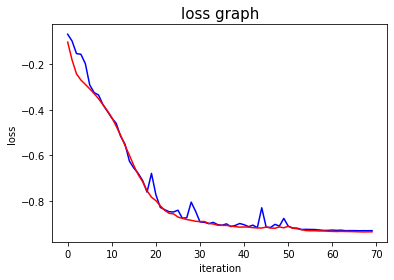

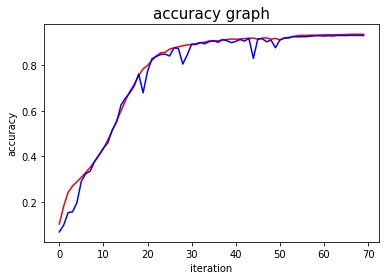

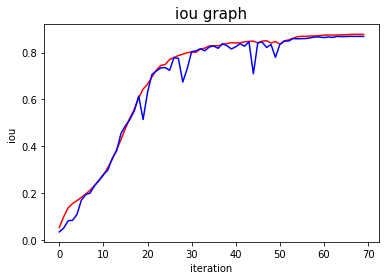

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)

plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)

plt.figure(3)
plt.plot(list_trainjaccard, 'r-')
plt.plot(list_testjaccard, 'b-')
plt.xlabel('iteration')
plt.ylabel('iou')
plt.title('iou graph', fontsize = 15)

plt.show()

## Run the model on the test set
After your last Q&A session, you will be given the test set. Run your model on the test set to get the segmentation results and submit your results in a .zip file. If the MRI image is named '100_img.npy', save your segmentation result as '100_seg.npy'. 

In [ ]:
test_gen = DataGenerator(test_list)

results = model.evaluate(test_gen, steps=len(test_list) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

10/10 [===========================>..] - ETA: 0s - loss: -0.9317 - binary_accuracy: 0.9960 - iou: 0.8724 - dice_coef: 0.9317

10/10 [==============================] - 4s 401ms/step - loss: -0.9317 - binary_accuracy: 0.9960 - iou: 0.8724 - dice_coef: 0.9317
Test lost:  -0.9316713213920593
Test IOU:  0.9959549903869629
Test Dice Coefficent:  0.872381329536438


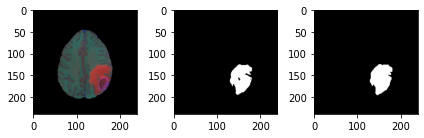

In [ ]:
prediction_list = []
truth_list = []
original_list = []


index=np.random.randint(1,len(test_list))
img1 = np.load(test_list[index]) # img图片
img1 = cv2.resize(img1 ,(im_height, im_width))

img2 = np.load(test_list[index].replace('_img','_seg')) # img图片
img2 = cv2.resize(img2 ,(im_height, im_width))
#img2 = (img2 - np.min(img2)) / (np.max(img2) - np.min(img2))

img = img1[np.newaxis, :, :, :]
prediction=model.predict(img)
prediction = np.squeeze(prediction)

img1 = (img1 - np.min(img1)) / (np.max(img1) - np.min(img1))
#print(prediction.shape)
plt.subplot(1,3,1)
plt.imshow(img1)
plt.subplot(1,3,2)
plt.imshow(img2, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(prediction, cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
img_files = glob('/content/drive/MyDrive/IC_DSI/Dataset/Test/imgs/*_img.npy')
#train_list, test_list = train_test_split(img_files,test_size = 0.03)
test_list = img_files
                                         
#print(len(train_list))
print(len(test_list))


new_model = load_model('/content/drive/MyDrive/IC_DSI/Model/trained_model_newepoch150.h5', compile=False)

#X = np.empty(shape=(len(test_list), (240,240), 1))
for i, ID in enumerate(test_list):
    print(ID)
    img1 = np.load(ID)
    x_test = cv2.resize(img1,(240, 240))
    x_test = x_test[np.newaxis, :, :, :]

    #img2 = np.load(ID.replace('_img.npy','_seg.npy')) # img图片
    #img2 = cv2.resize(img2 ,(240, 240))

    prediction = new_model.predict(x_test)
    prediction = np.squeeze(prediction) > 0.5 # 变为0和1
    prediction = np.uint8(prediction)  # 转化为uint8格式
    print(prediction.shape)
    print(prediction.dtype)
    print(np.unique(prediction))
    img1 = (img1 - np.min(img1)) / (np.max(img1) - np.min(img1))

    new_place = ID.replace('_img','_seg')
    nnew_place = new_place.replace('imgs','Uint8TestYYY')
    #np.save(nnew_place, prediction)
    print(nnew_place)


    plt.subplot(1,3,1)
    plt.imshow(img1)
    plt.subplot(1,3,3)
    plt.imshow(prediction, cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(img1[:,:,0])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.